In [1]:
import pandas as pd

result_df = pd.read_parquet('/content/sleep_result_44659288-6985ad26-e34f-4a9e-bccc-7f3d326b8b72.parquet')
result_df = result_df.dropna(axis=1, how='all')

score_df = pd.read_parquet('/content/sleep_score_44659288-1638f8a8-b506-406b-9143-857be7e41a68.parquet')
score_df = score_df.dropna(axis=1, how='all')

df = pd.merge(result_df, score_df, on='night', how='inner')
df.head(3)

,night,evaluation_sleepType,evaluation_sleepSpan,evaluation_asleepDuration,evaluation_age,evaluation_analysis_efficiencyPercent,evaluation_analysis_continuityIndex,evaluation_analysis_continuityClass,evaluation_analysis_feedback,evaluation_interruptions_totalDuration,...,sleepScoreBaselines_continuityScoreBaseline,sleepScoreBaselines_continuityScoreAverage,sleepScoreBaselines_efficiencyScoreBaseline,sleepScoreBaselines_efficiencyPercentAverage,sleepScoreBaselines_groupRefreshScoreBaseline,sleepScoreBaselines_remScoreBaseline,sleepScoreBaselines_remPercentAverage,sleepScoreBaselines_n3ScoreBaseline,sleepScoreBaselines_n3PercentAverage,sleepScoreBaselines_sleepScoreBaseline
0,2020-04-28,SLEEP_PLUS_STAGES,PT7H6M30S,PT6H36M30S,30.655738,92.966002,2.7,2,10,PT30M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-04-29,SLEEP_PLUS_STAGES,PT4H32M30S,PT4H19M,30.658470,95.045872,4.1,4,1110,PT13M30S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-04-30,SLEEP_PLUS_STAGES,PT7H11M30S,PT6H44M,30.661202,93.626883,2.6,2,10,PT27M30S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
for col in df.columns:
    print(col)

night
evaluation_sleepType
evaluation_sleepSpan
evaluation_asleepDuration
evaluation_age
evaluation_analysis_efficiencyPercent
evaluation_analysis_continuityIndex
evaluation_analysis_continuityClass
evaluation_analysis_feedback
evaluation_interruptions_totalDuration
evaluation_interruptions_totalCount
evaluation_interruptions_shortDuration
evaluation_interruptions_shortCount
evaluation_interruptions_longDuration
evaluation_interruptions_longCount
sleepResult_hypnogram_sleepStart
sleepResult_hypnogram_sleepEnd
sleepResult_hypnogram_alarmSnoozeTimes
sleepResult_hypnogram_sleepStateChanges
sleepResult_hypnogram_sleepStartOffset
sleepResult_hypnogram_sleepEndOffset
sleepResult_hypnogram_rating
sleepResult_hypnogram_birthday
sleepResult_hypnogram_sleepGoal
sleepResult_hypnogram_deviceId
sleepResult_hypnogram_batteryRanOut
evaluation_phaseDurations_wake
evaluation_phaseDurations_rem
evaluation_phaseDurations_light
evaluation_phaseDurations_deep
evaluation_phaseDurations_unknown
evaluation_ph

Data Shape: (238, 85)

Column Names:
 ['night', 'evaluation_sleepType', 'evaluation_sleepSpan', 'evaluation_asleepDuration', 'evaluation_age', 'evaluation_analysis_efficiencyPercent', 'evaluation_analysis_continuityIndex', 'evaluation_analysis_continuityClass', 'evaluation_analysis_feedback', 'evaluation_interruptions_totalDuration', 'evaluation_interruptions_totalCount', 'evaluation_interruptions_shortDuration', 'evaluation_interruptions_shortCount', 'evaluation_interruptions_longDuration', 'evaluation_interruptions_longCount', 'sleepResult_hypnogram_sleepStart', 'sleepResult_hypnogram_sleepEnd', 'sleepResult_hypnogram_alarmSnoozeTimes', 'sleepResult_hypnogram_sleepStateChanges', 'sleepResult_hypnogram_sleepStartOffset', 'sleepResult_hypnogram_sleepEndOffset', 'sleepResult_hypnogram_rating', 'sleepResult_hypnogram_birthday', 'sleepResult_hypnogram_sleepGoal', 'sleepResult_hypnogram_deviceId', 'sleepResult_hypnogram_batteryRanOut', 'evaluation_phaseDurations_wake', 'evaluation_phaseDur

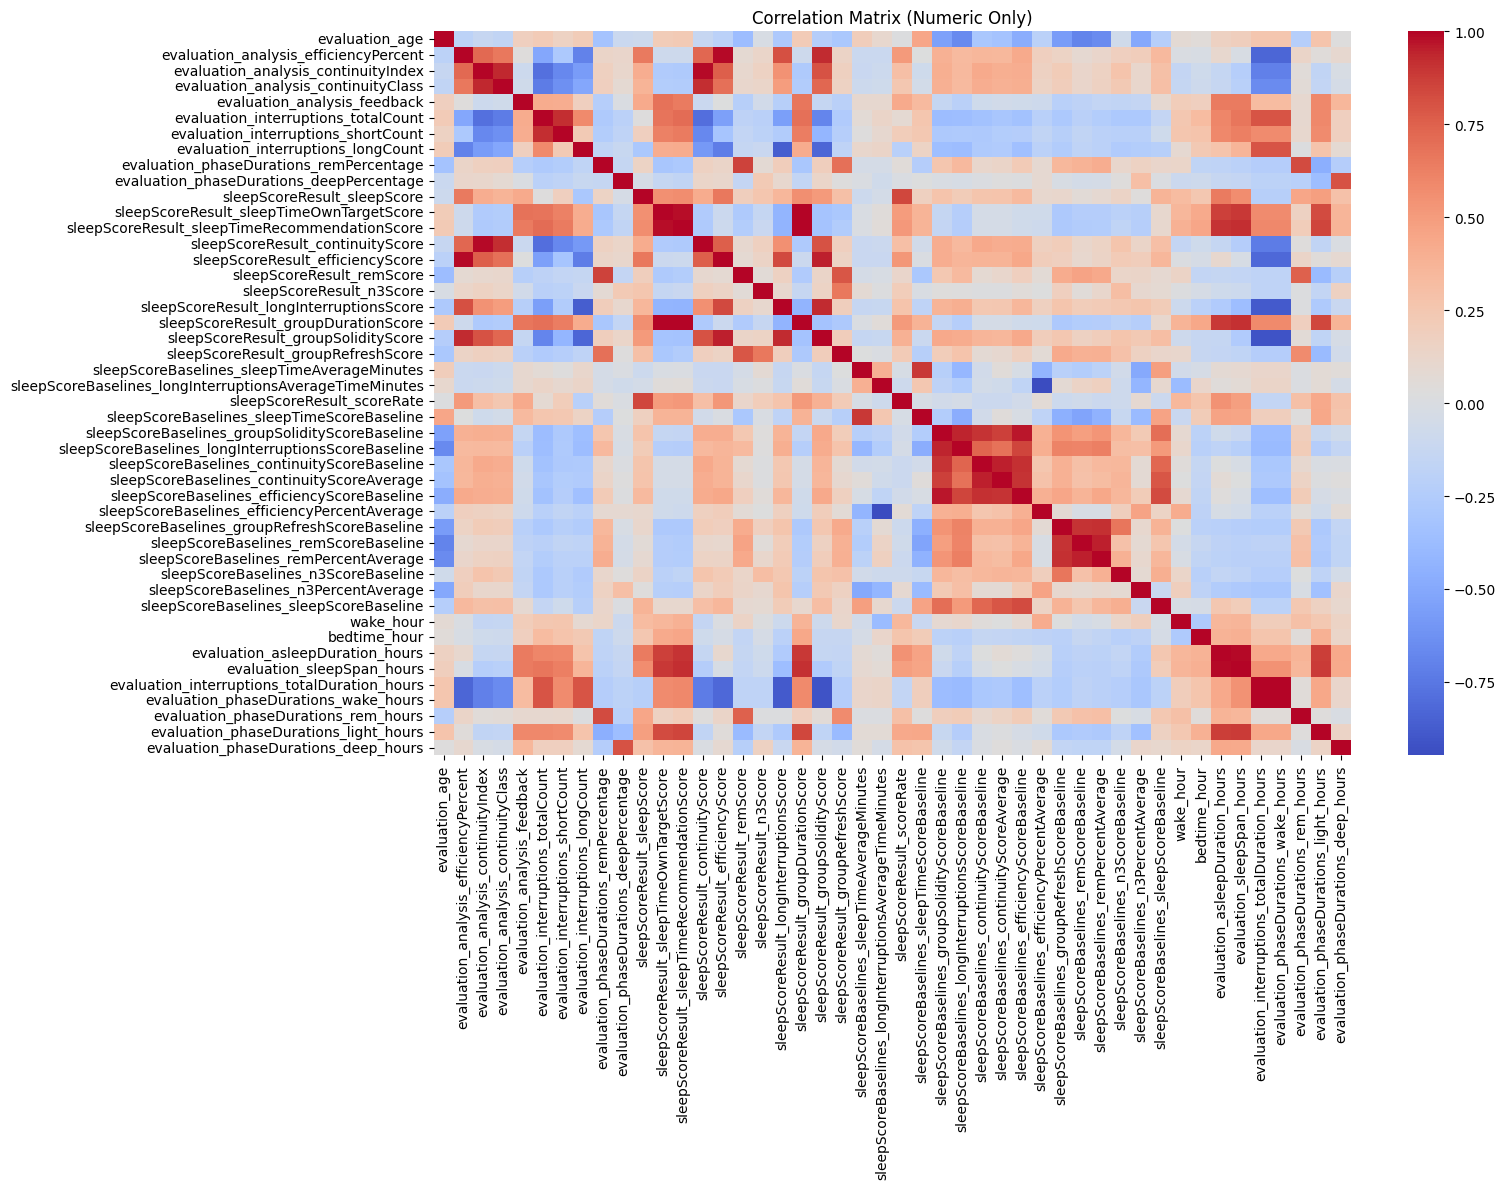

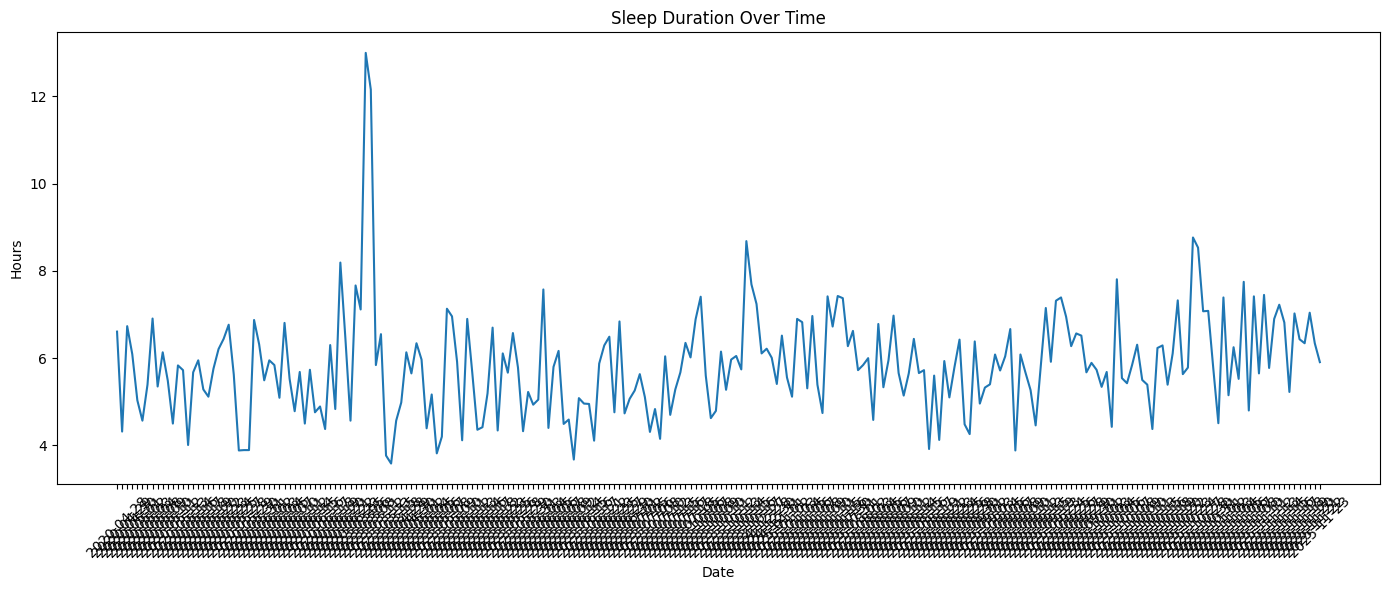

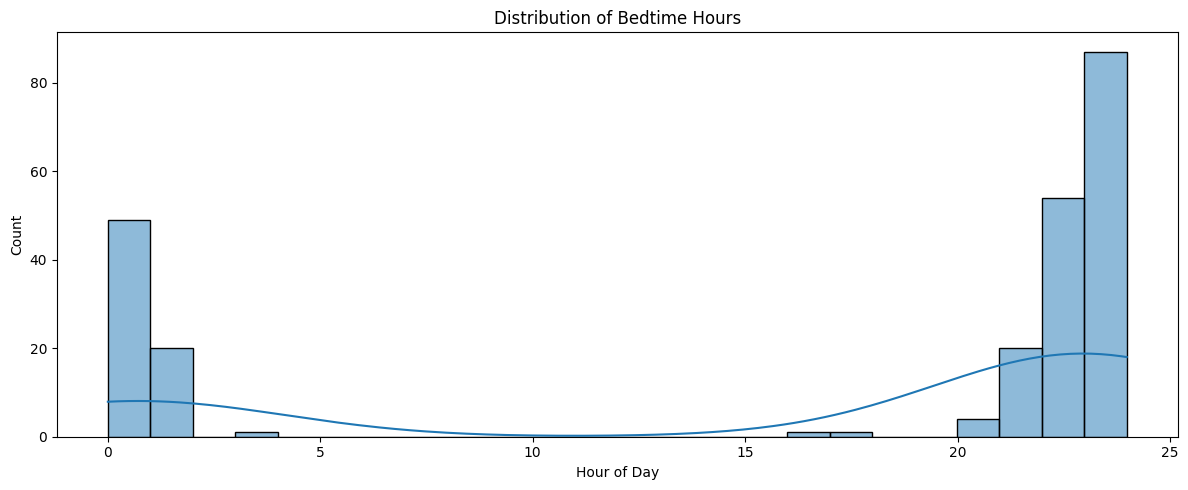

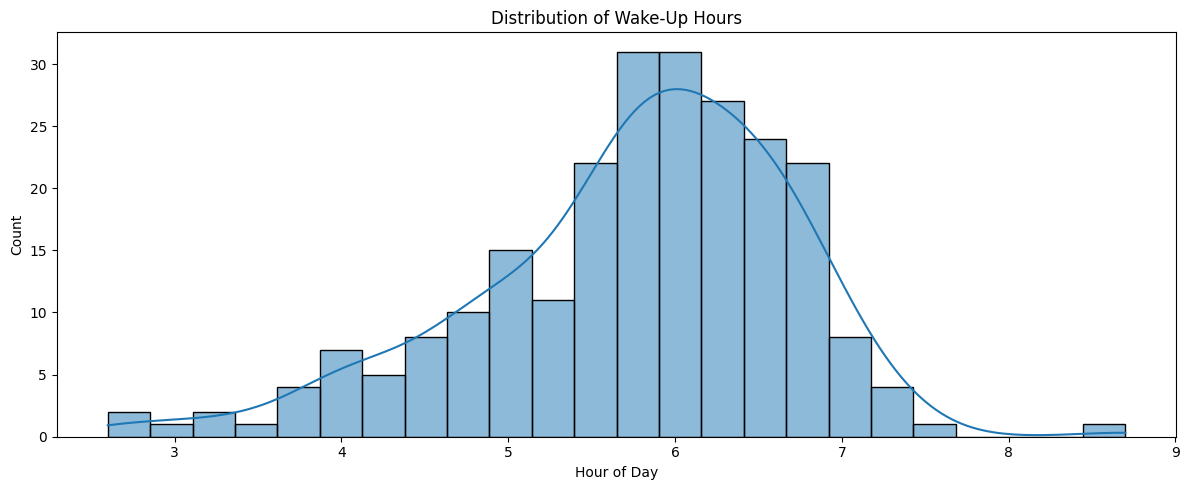

<Figure size 1200x600 with 0 Axes>

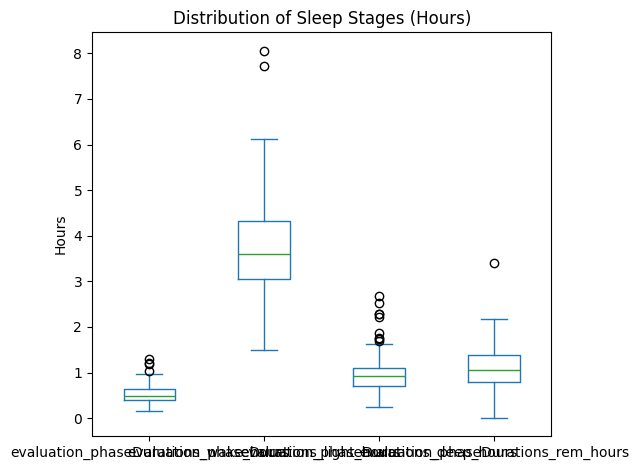

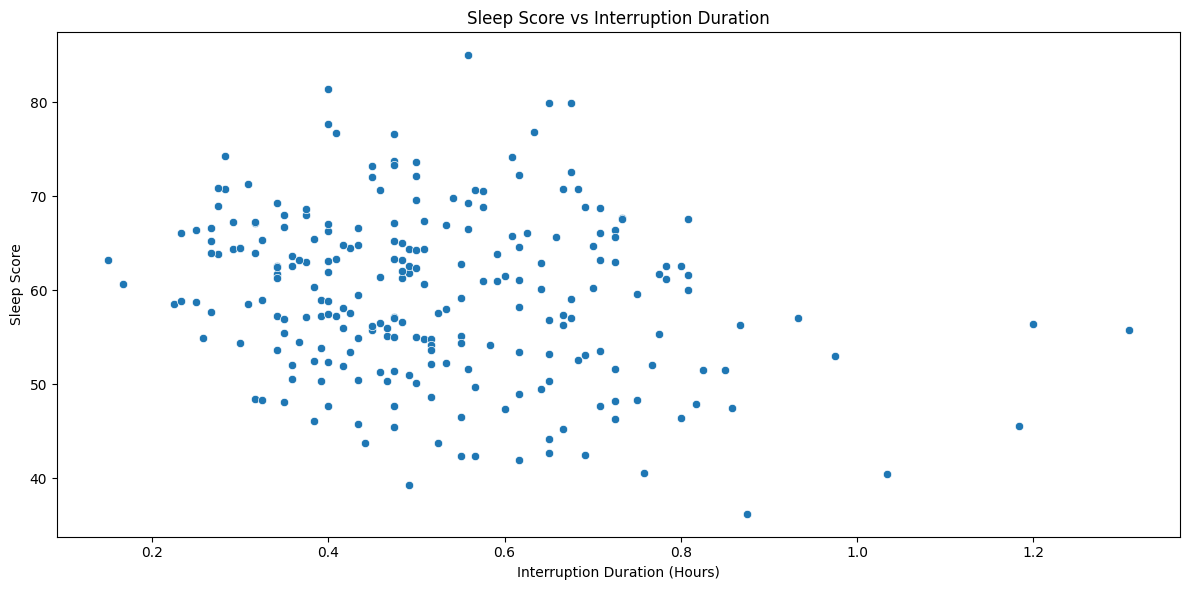

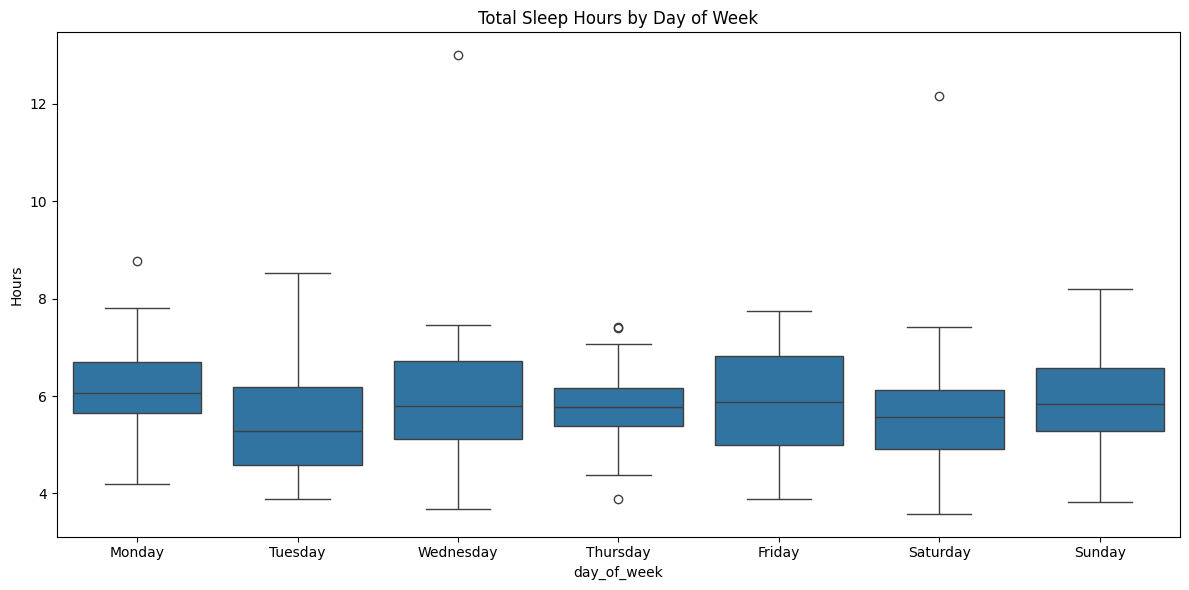

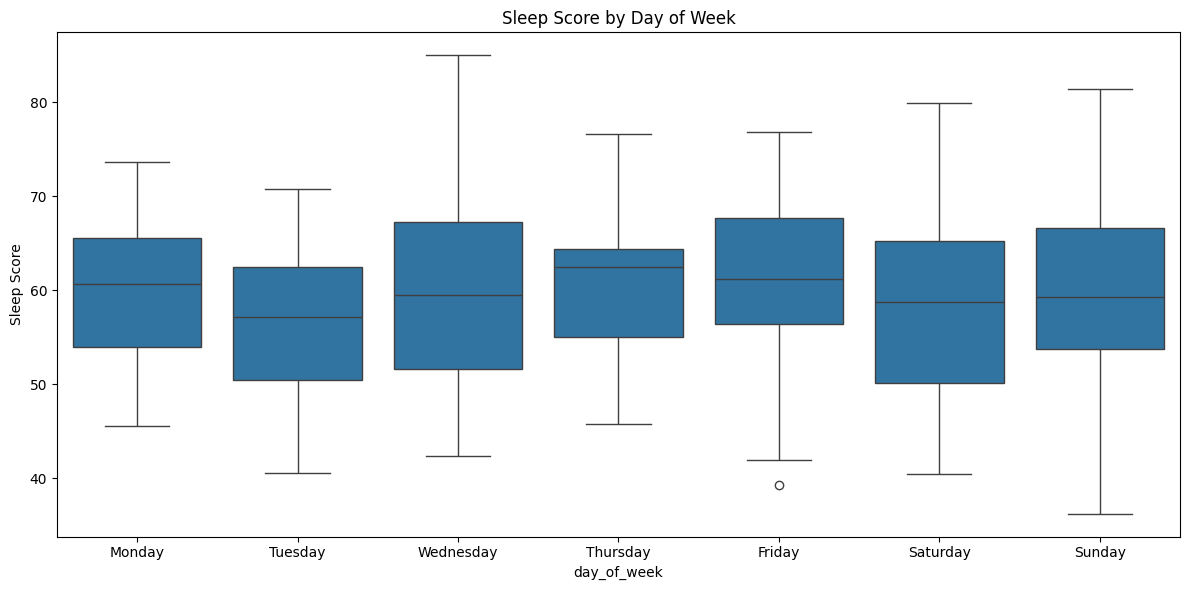

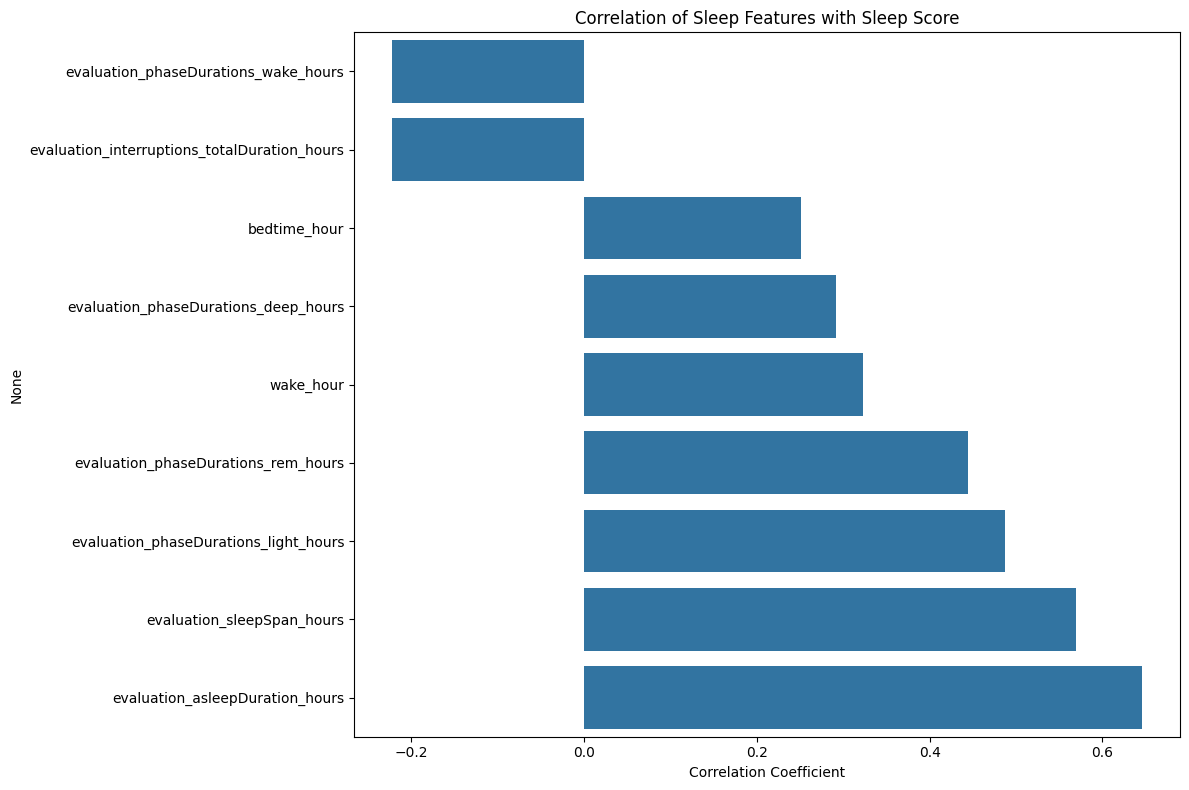

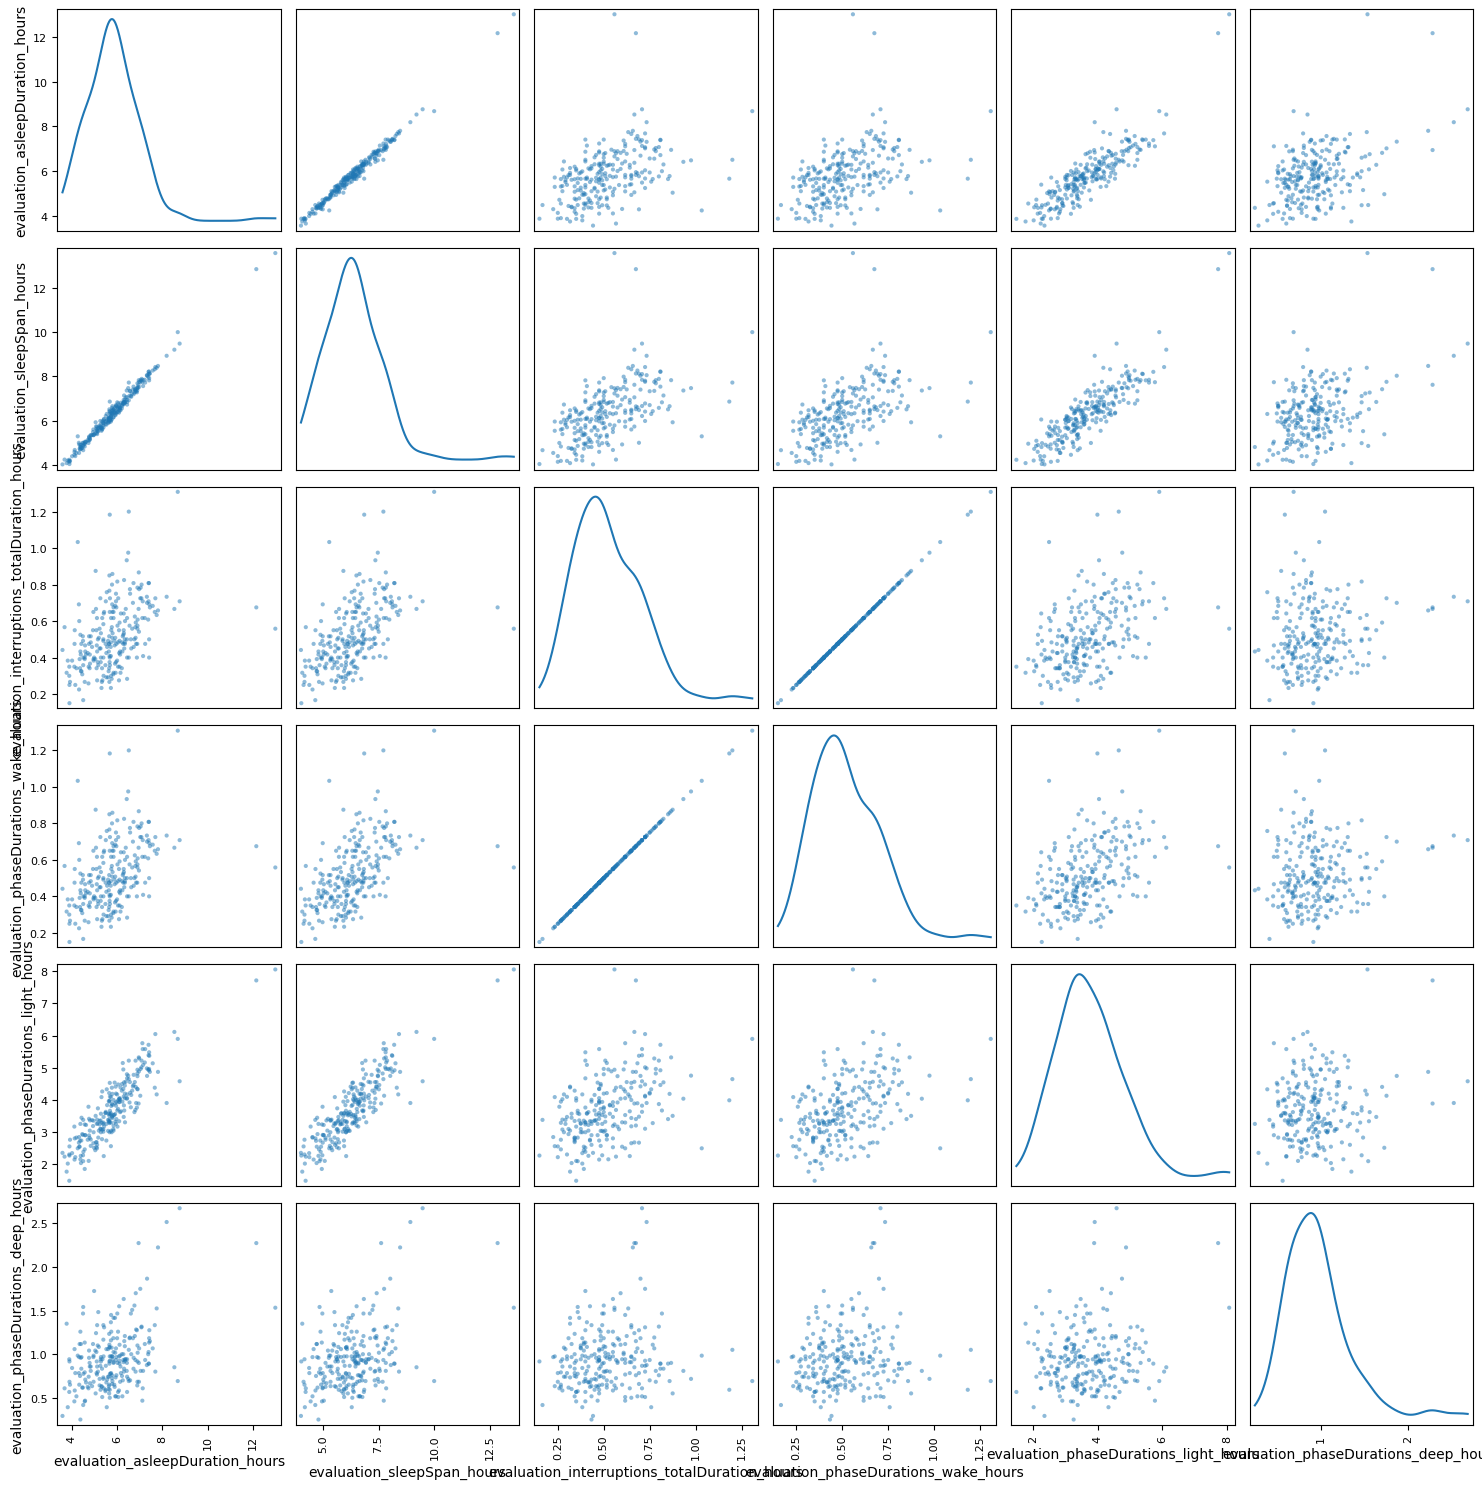


--- Actionable Sleep Insights ---
- Try to maintain a consistent bedtime to improve sleep quality.
- Minimize interruptions during sleep (noise, light, phone usage).
- Focus on increasing deep sleep: relaxation, avoid late caffeine/alcohol, optimize bedroom environment.
- REM sleep might be low: consider stress reduction, regular exercise, and consistent sleep schedule.
- Aim for at least 7-8 hours of sleep per night.
- Check correlations with sleep score to identify personal factors that most affect your sleep.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

# -----------------------------
# 1. Load and merge data
# -----------------------------
result_df = pd.read_parquet('/content/sleep_result_44659288-6985ad26-e34f-4a9e-bccc-7f3d326b8b72.parquet')
result_df = result_df.dropna(axis=1, how='all')

score_df = pd.read_parquet('/content/sleep_score_44659288-1638f8a8-b506-406b-9143-857be7e41a68.parquet')
score_df = score_df.dropna(axis=1, how='all')

df = pd.merge(result_df, score_df, on='night', how='inner')

# -----------------------------
# 2. Parse datetime columns
# -----------------------------
df['sleep_start'] = pd.to_datetime(df['sleepResult_hypnogram_sleepStart'], errors='coerce', utc=True)
df['sleep_end'] = pd.to_datetime(df['sleepResult_hypnogram_sleepEnd'], errors='coerce', utc=True)
df['sleep_start'] = df['sleep_start'].dt.tz_convert('Asia/Ho_Chi_Minh')
df['sleep_end'] = df['sleep_end'].dt.tz_convert('Asia/Ho_Chi_Minh')

df['wake_hour'] = df['sleep_end'].dt.hour + df['sleep_end'].dt.minute / 60
df['bedtime_hour'] = df['sleep_start'].dt.hour + df['sleep_start'].dt.minute / 60
df['day_of_week'] = df['sleep_end'].dt.day_name()

# -----------------------------
# 3. Parse duration strings
# -----------------------------
def parse_duration(duration_str):
    if pd.isna(duration_str):
        return np.nan
    try:
        duration_str = str(duration_str)
        hours = minutes = seconds = 0

        # Extract hours
        if 'H' in duration_str:
            hours = int(duration_str.split('H')[0].split('T')[-1])
            duration_str = duration_str.split('H')[1]
        else:
            duration_str = duration_str.split('T')[-1]

        # Extract minutes
        if 'M' in duration_str:
            minutes = int(duration_str.split('M')[0])
            duration_str = duration_str.split('M')[1]

        # Extract seconds
        if 'S' in duration_str:
            seconds = float(duration_str.replace('S', ''))

        return hours + minutes / 60 + seconds / 3600
    except:
        return np.nan

sleep_duration_cols = [
    'evaluation_asleepDuration', 'evaluation_sleepSpan', 'evaluation_interruptions_totalDuration',
    'evaluation_phaseDurations_wake', 'evaluation_phaseDurations_rem',
    'evaluation_phaseDurations_light', 'evaluation_phaseDurations_deep'
]

for col in sleep_duration_cols:
    if col in df.columns:
        df[col + '_hours'] = df[col].apply(parse_duration)

# -----------------------------
# 4. Basic overview
# -----------------------------
print("Data Shape:", df.shape)
print("\nColumn Names:\n", df.columns.tolist())
print("\nMissing Values:\n", df.isna().sum().head(20))

# -----------------------------
# 5. Safe numeric columns for correlation
# -----------------------------
# Get numeric columns first
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Filter out problematic columns and ensure they're truly numeric
valid_numeric_cols = []
for col in numeric_cols:
    try:
        # Test if column can be used in correlation
        test_series = pd.to_numeric(df[col], errors='coerce')
        # Check if column has any non-null values and isn't constant
        if test_series.notna().sum() > 0 and test_series.std() != 0:
            df[col] = test_series
            valid_numeric_cols.append(col)
    except:
        continue

# Remove columns with complex data structures
exclude_patterns = ['cycles', 'Models', 'Backup', '__array']
valid_numeric_cols = [c for c in valid_numeric_cols
                      if not any(pattern in c for pattern in exclude_patterns)]

print(f"\nValid numeric columns for analysis: {len(valid_numeric_cols)}")

# -----------------------------
# 6. Correlation heatmap (with error handling)
# -----------------------------
if len(valid_numeric_cols) > 1:
    try:
        plt.figure(figsize=(16,12))
        corr_matrix = df[valid_numeric_cols].corr()
        sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm')
        plt.title("Correlation Matrix (Numeric Only)")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not create correlation heatmap: {e}")

# -----------------------------
# 7. Sleep duration over time
# -----------------------------
if 'evaluation_asleepDuration_hours' in df.columns:
    plt.figure(figsize=(14,6))
    sns.lineplot(data=df, x='night', y='evaluation_asleepDuration_hours')
    plt.title("Sleep Duration Over Time")
    plt.ylabel("Hours")
    plt.xlabel("Date")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 8. Bedtime and wake-up distributions
# -----------------------------
if 'bedtime_hour' in df.columns:
    plt.figure(figsize=(12,5))
    sns.histplot(df['bedtime_hour'], bins=24, kde=True)
    plt.title("Distribution of Bedtime Hours")
    plt.xlabel("Hour of Day")
    plt.tight_layout()
    plt.show()

if 'wake_hour' in df.columns:
    plt.figure(figsize=(12,5))
    sns.histplot(df['wake_hour'], bins=24, kde=True)
    plt.title("Distribution of Wake-Up Hours")
    plt.xlabel("Hour of Day")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 9. Sleep stages analysis
# -----------------------------
stages = ['evaluation_phaseDurations_wake_hours', 'evaluation_phaseDurations_light_hours',
          'evaluation_phaseDurations_deep_hours', 'evaluation_phaseDurations_rem_hours']
stages = [s for s in stages if s in df.columns]

if stages:
    plt.figure(figsize=(12,6))
    df[stages].plot(kind='box')
    plt.title("Distribution of Sleep Stages (Hours)")
    plt.ylabel("Hours")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 10. Sleep score vs interruptions
# -----------------------------
if 'evaluation_interruptions_totalDuration_hours' in df.columns and 'sleepScoreResult_sleepScore' in df.columns:
    plt.figure(figsize=(12,6))
    sns.scatterplot(data=df, x='evaluation_interruptions_totalDuration_hours', y='sleepScoreResult_sleepScore')
    plt.title("Sleep Score vs Interruption Duration")
    plt.xlabel("Interruption Duration (Hours)")
    plt.ylabel("Sleep Score")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 11. Day of week patterns
# -----------------------------
if 'day_of_week' in df.columns and 'evaluation_asleepDuration_hours' in df.columns:
    plt.figure(figsize=(12,6))
    sns.boxplot(data=df, x='day_of_week', y='evaluation_asleepDuration_hours',
                order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
    plt.title("Total Sleep Hours by Day of Week")
    plt.ylabel("Hours")
    plt.tight_layout()
    plt.show()

if 'day_of_week' in df.columns and 'sleepScoreResult_sleepScore' in df.columns:
    plt.figure(figsize=(12,6))
    sns.boxplot(data=df, x='day_of_week', y='sleepScoreResult_sleepScore',
                order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
    plt.title("Sleep Score by Day of Week")
    plt.ylabel("Sleep Score")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 12. Correlation with sleep score
# -----------------------------
sleep_related_cols = [
    'evaluation_asleepDuration_hours', 'evaluation_sleepSpan_hours',
    'evaluation_interruptions_totalDuration_hours', 'evaluation_phaseDurations_wake_hours',
    'evaluation_phaseDurations_light_hours', 'evaluation_phaseDurations_deep_hours',
    'evaluation_phaseDurations_rem_hours', 'bedtime_hour', 'wake_hour'
]
sleep_related_cols = [c for c in sleep_related_cols if c in df.columns]

if sleep_related_cols and 'sleepScoreResult_sleepScore' in df.columns:
    try:
        plt.figure(figsize=(12,8))
        corr_sleep_score = df[sleep_related_cols + ['sleepScoreResult_sleepScore']].corr()['sleepScoreResult_sleepScore'].sort_values()
        corr_sleep_score = corr_sleep_score[corr_sleep_score.index != 'sleepScoreResult_sleepScore']
        sns.barplot(x=corr_sleep_score.values, y=corr_sleep_score.index)
        plt.title("Correlation of Sleep Features with Sleep Score")
        plt.xlabel("Correlation Coefficient")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not create sleep score correlation plot: {e}")

# -----------------------------
# 13. Scatter matrix
# -----------------------------
if len(sleep_related_cols) >= 2:
    try:
        scatter_matrix(df[sleep_related_cols[:6]], figsize=(15,15), diagonal='kde')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not create scatter matrix: {e}")

# -----------------------------
# 14. Actionable insights
# -----------------------------
print("\n--- Actionable Sleep Insights ---")

if 'bedtime_hour' in df.columns and df['bedtime_hour'].std() > 1:
    print("- Try to maintain a consistent bedtime to improve sleep quality.")

if 'wake_hour' in df.columns and df['wake_hour'].std() > 1:
    print("- Try to maintain a consistent wake-up time, even on weekends.")

if 'evaluation_interruptions_totalDuration_hours' in df.columns and df['evaluation_interruptions_totalDuration_hours'].mean() > 0.5:
    print("- Minimize interruptions during sleep (noise, light, phone usage).")

if 'evaluation_phaseDurations_deep_hours' in df.columns and df['evaluation_phaseDurations_deep_hours'].mean() < 1.5:
    print("- Focus on increasing deep sleep: relaxation, avoid late caffeine/alcohol, optimize bedroom environment.")

if 'evaluation_phaseDurations_rem_hours' in df.columns and df['evaluation_phaseDurations_rem_hours'].mean() < 1.5:
    print("- REM sleep might be low: consider stress reduction, regular exercise, and consistent sleep schedule.")

if 'evaluation_asleepDuration_hours' in df.columns and df['evaluation_asleepDuration_hours'].mean() < 7:
    print("- Aim for at least 7-8 hours of sleep per night.")

print("- Check correlations with sleep score to identify personal factors that most affect your sleep.")